In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer,OneHotEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = "https://frenzy86.s3.eu-west-2.amazonaws.com/python/penguins.csv"

df = pd.read_csv(path)
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,male
1,Adelie,Torgersen,39.5,17.4,186,3800,female
2,Adelie,Torgersen,40.3,18.0,195,3250,female
3,Adelie,Torgersen,36.7,19.3,193,3450,female
4,Adelie,Torgersen,39.3,20.6,190,3650,male
...,...,...,...,...,...,...,...
328,Chinstrap,Dream,55.8,19.8,207,4000,male
329,Chinstrap,Dream,43.5,18.1,202,3400,female
330,Chinstrap,Dream,49.6,18.2,193,3775,male
331,Chinstrap,Dream,50.8,19.0,210,4100,male


<Axes: >

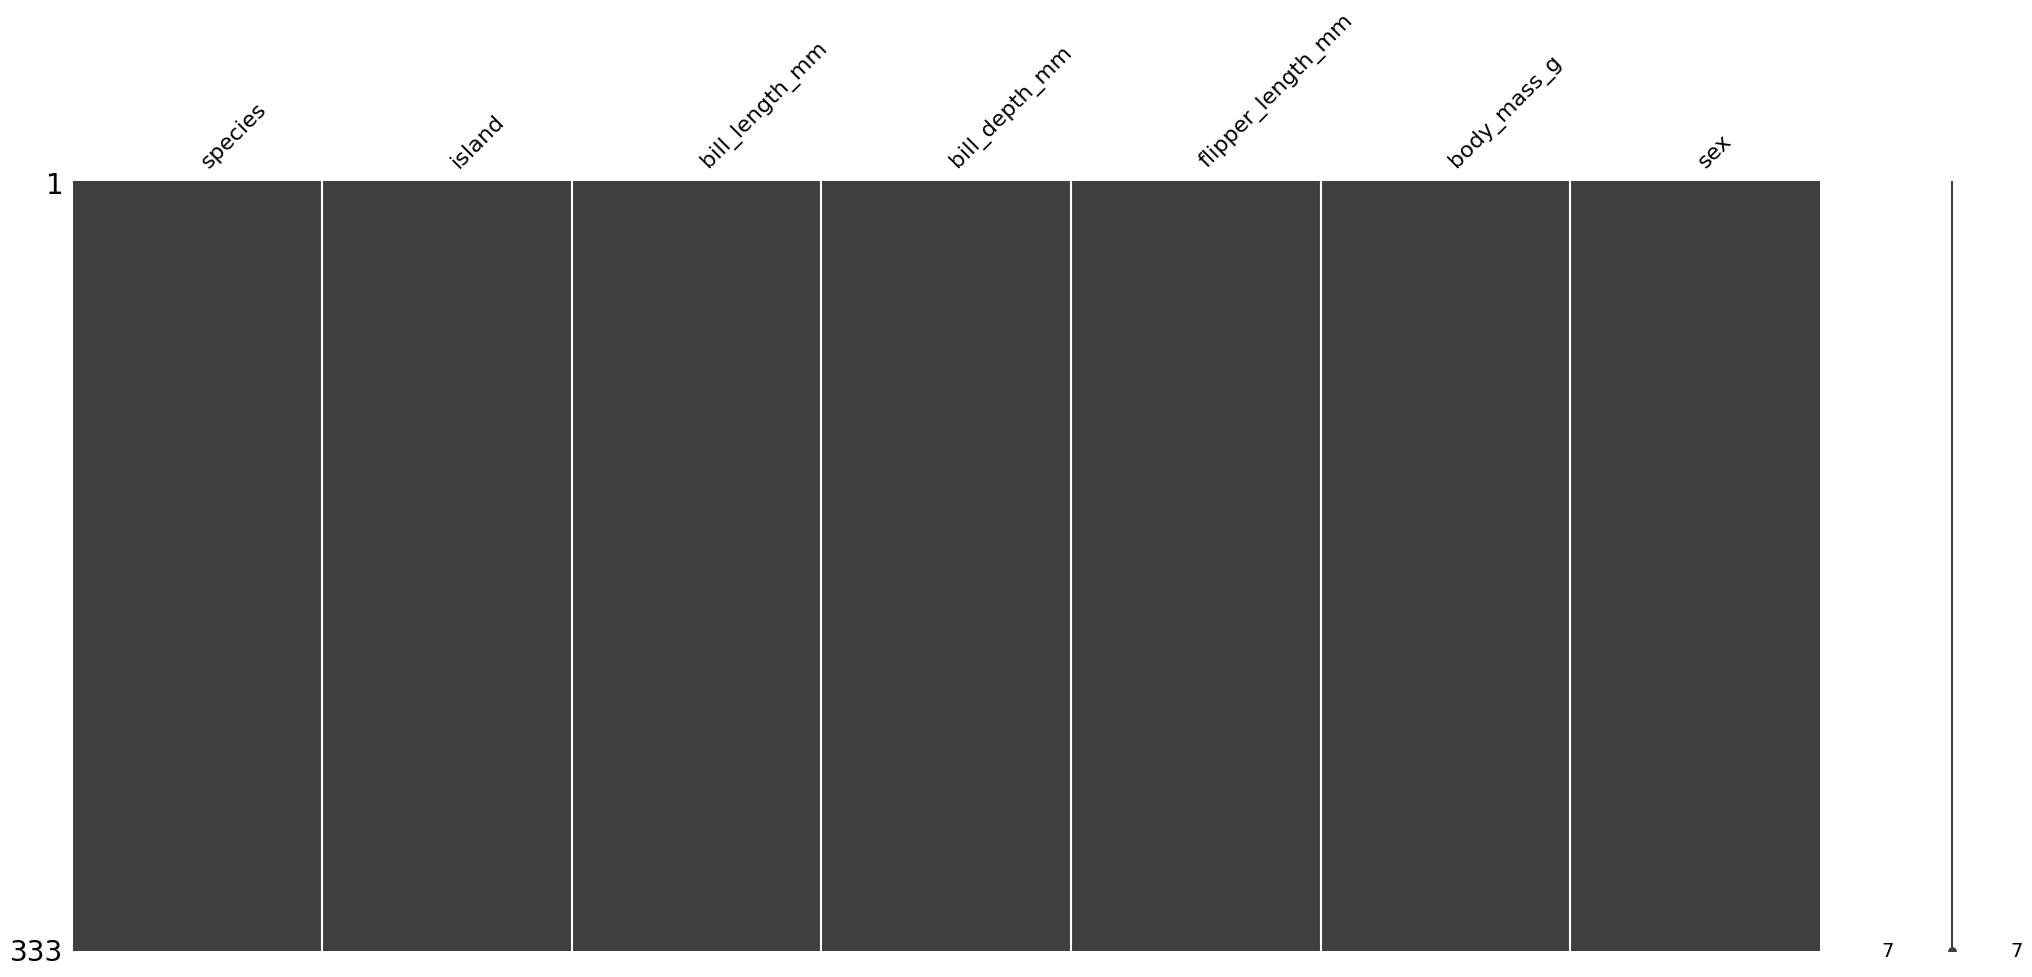

In [3]:
import missingno as msno
msno.matrix(df)

In [4]:
df['species'].value_counts()

species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64

In [5]:
## TARGET NUMERICAL
df['species'] = df['species'].map({'Adelie':0,'Gentoo':1,'Chinstrap':2})

In [6]:
#STEP 0 FILTERING
#remove features not useful
features_to_remove = []
df_clean = df.drop(features_to_remove, axis=1)

In [7]:
# STEP 1 - TRAIN TEST SPLITTING
#Feature matrix and target vector
X = df_clean.drop(['species'], axis=1) # matrice Features
y = df_clean['species']                #Target

## Simple Imputer
https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

Il SimpleImputer è utilizzato per gestire i valori mancanti (NaN) all'interno dei dati. Nella tua pipeline, viene utilizzato per imputare i valori mancanti nelle feature numeriche, sostituendoli con la mediana dei valori presenti in quella colonna.

Ad esempio, supponiamo di avere una feature numerica come l'età di una persona e alcuni valori sono mancanti. Utilizzando SimpleImputer(strategy='median'), verranno sostituiti i valori mancanti con la mediana dell'età di tutte le altre persone.

Questo aiuta a mantenere la completezza dei dati durante l'analisi, poiché molti algoritmi di machine learning non possono gestire direttamente i valori mancanti.

- Se impostato su "mean", sostituisce i valori mancanti utilizzando la media lungo ciascuna colonna. Può essere utilizzato solo con dati numerici.

- Se impostato su "median", sostituisce i valori mancanti utilizzando la mediana lungo ciascuna colonna. Può essere utilizzato solo con dati numerici.

- Se impostato su "most_frequent", sostituisce i valori mancanti utilizzando il valore più frequente lungo ciascuna colonna. Può essere utilizzato con dati di tipo stringa o numerici. Se ci sono più valori più frequenti, viene restituito solo il più piccolo.

- Se impostato su "constant", sostituisce i valori mancanti con il valore specificato in fill_value. Può essere utilizzato con dati di tipo stringa o numerici.



In [8]:
X.columns

Index(['island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'sex'],
      dtype='object')

In [9]:
## dividiamo automaticamente le features numeriche da quelle categoriche

numerical_features = [x for x, dtype in zip(X.columns, X.dtypes) if dtype.kind in ['i','f'] ]
categorical_features = [x for x, dtype in zip(X.columns, X.dtypes) if dtype.kind not in ['i','f']]

print('Numerical : ' + str(numerical_features))
print('Categorical : ' + str(categorical_features))

Numerical : ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
Categorical : ['island', 'sex']


In [10]:
## Parte di processingdata: Cleaning, fill Nan + OHE
Preprocessor = make_column_transformer(
                                        (make_pipeline(
                                        SimpleImputer(strategy = 'median'),
                                        KBinsDiscretizer(n_bins=3)), numerical_features),

                                        (make_pipeline(
                                        #FunctionTransformer(lambda x: np.where(x == 'n.d.', np.nan, x)),
                                        SimpleImputer(strategy = 'constant', fill_value = 'missing'),
                                        OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features)
                                        )

In [11]:
scaler = StandardScaler()

classifier = LogisticRegression(
                                C=1.0,
                                penalty='l1',
                                solver='liblinear',
                                )

In [12]:
model_pipe = Pipeline([
                       ('Preprocessing features', Preprocessor),
                       ('Scaling and standadize data', scaler),
                       ('Classifier', classifier)
                      ])
model_pipe

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['island', 'sex'])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Classifier',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

In [13]:
cross_val_scores = cross_val_score(model_pipe, X, y, cv=5)
print(cross_val_scores)

# Calcola la media e la deviazione standard dei punteggi
mean_score = np.mean(cross_val_scores)
std_score = np.std(cross_val_scores)

print(f"Mean cross-validation score:{mean_score:.2f}")
print(f"Standard deviation of cross-validation scores:{std_score:.2f}")

[1.         0.98507463 1.         1.         1.        ]
Mean cross-validation score:1.00
Standard deviation of cross-validation scores:0.01


##Fit the model with entire dataset

<img src='https://frenzy86.s3.eu-west-2.amazonaws.com/python/cross.png' width=600>


In [14]:
model_pipe.fit(X, y)

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['island', 'sex'])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Classifier',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

In [15]:
y_pred_tot = model_pipe.predict(X)

In [16]:
from sklearn.metrics import classification_report

classification_report(y,y_pred_tot )

classification_report_result = classification_report(y, y_pred_tot)
print(classification_report_result)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       146
           1       1.00      1.00      1.00       119
           2       0.99      1.00      0.99        68

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333



## Prediction of single observation

In [17]:
X.columns

Index(['island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'sex'],
      dtype='object')

In [18]:
X.iloc[0]

island               Torgersen
bill_length_mm            39.1
bill_depth_mm             18.7
flipper_length_mm          181
body_mass_g               3750
sex                       male
Name: 0, dtype: object

In [19]:
island= 'Torgersen'
bill_length_mm = 39.1
bill_depth_mm = 18.7
flipper_length_mm = 181
body_mass_g = 3750
sex = 'male'

data = {
        "island": [island],
        "bill_length_mm": [bill_length_mm],
        "bill_depth_mm": [bill_depth_mm],
        "flipper_length_mm":[flipper_length_mm],
        "body_mass_g": [body_mass_g],
        "sex": [sex],
        }

input_df = pd.DataFrame(data)
res = model_pipe.predict(input_df).astype(int)[0]
print(res)

classes = {0:'Adelie',
           1:'Gentoo',
           2:'Chinstrap',
           }

y_pred = classes[res]
y_pred

0


'Adelie'

In [20]:
import joblib

joblib.dump(model_pipe,'penguinspipe.pkl')

['penguinspipe.pkl']

## Load model .pkl

In [21]:
import joblib

model_pipe = joblib.load('penguinspipe.pkl')
print('Model loaded successfully')

Model loaded successfully


In [22]:
model_pipe

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['island', 'sex'])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Classifier',
                 LogisticRegression(penalty='l1', solver='liblinear'))])